<a href="https://colab.research.google.com/github/sowmyamanojna/CS6024-Algorithmic-Approaches-to-Computational-Biology-Project/blob/master/codes/vae_dae/dae_retrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%tensorflow_version 1.x
import tensorflow as tf

from keras import backend as K
from keras import optimizers
from keras.layers import Input, Dense, Lambda, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.regularizers import l1

from keras import activations
from keras import backend as K
from keras.layers import Layer

from keras.utils import plot_model

from keras.callbacks import Callback
from keras.layers import Layer
from keras import metrics

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
# From tybalt.utils.adage_utils
class TiedWeightsDecoder(Layer):
    """
    Transpose the encoder weights to apply decoding of compressed latent space
    """
    def __init__(self, output_dim, encoder, activation=None, **kwargs):
        self.output_dim = output_dim
        self.encoder = encoder
        self.activation = activations.get(activation)
        super(TiedWeightsDecoder, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.encoder.weights
        super(TiedWeightsDecoder, self).build(input_shape)

    def call(self, x):
        # Encoder weights: [weight_matrix, bias_term]
        output = K.dot(x - self.encoder.weights[1],
                       K.transpose(self.encoder.weights[0]))
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [4]:
# From tybalt.utils.base
class BaseModel():
    def __init__(self):
        pass

    def get_summary(self):
        self.full_model.summary()

    def visualize_architecture(self, output_file):
        # Visualize the connections of the custom VAE model
        plot_model(self.full_model, to_file=output_file)

    def visualize_training(self, output_file=None):
        # Visualize training performance
        history_df = pd.DataFrame(self.hist.history)
        ax = history_df.plot()
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        fig = ax.get_figure()
        if output_file:
            fig.savefig(output_file)
        else:
            fig.show()

    def get_weights(self, decoder=True):
        # Extract weight matrices from encoder or decoder
        weights = []
        if decoder:
            for layer in self.decoder.layers:
                weights.append(layer.get_weights())
        else:
            for layer in self.encoder.layers:
                # Encoder weights must be transposed
                encoder_weights = layer.get_weights()
                encoder_weights = [np.transpose(x) for x in encoder_weights]
                weights.append(encoder_weights)
        return weights

    def save_models(self, encoder_file, decoder_file):
        self.encoder.save(encoder_file)
        self.decoder.save(decoder_file)


class VAE(BaseModel):
    def __init__(self):
        BaseModel.__init__(self)

    def _sampling(self, args):
        """
        Function for reparameterization trick to make model differentiable
        """
        # Function with args required for Keras Lambda function
        z_mean, z_log_var = args

        # Draw epsilon of the same shape from a standard normal distribution
        epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                                  stddev=self.epsilon_std)

        # The latent vector is non-deterministic and differentiable
        # in respect to z_mean and z_log_var
        z = z_mean + K.exp(z_log_var / 2) * epsilon
        return z

    def initialize_model(self):
        """
        Helper function to run that builds and compiles Keras layers
        """
        self._build_encoder_layer()
        self._build_decoder_layer()
        self._compile_vae()
        self._connect_layers()

    def compress(self, df):
        # Encode rnaseq into the hidden/latent representation - and save output
        # a cVAE expects a list of [rnaseq_df, y_df]
        encoded_df = self.encoder.predict_on_batch(df)

        if self.model_name == 'cTybalt':
            named_index = df[0].index
        else:
            named_index = df.index

        encoded_df = pd.DataFrame(encoded_df,
                                  columns=range(1, self.latent_dim + 1),
                                  index=named_index)
        return encoded_df

In [5]:
# From tybalt.utils.vae_utils
def approx_keras_binary_cross_entropy(x, z, p, epsilon=1e-07):
    """
    Function to approximate Keras `binary_crossentropy()`
    https://github.com/keras-team/keras/blob/e6c3f77b0b10b0d76778109a40d6d3282f1cadd0/keras/losses.py#L76
    Which is a wrapper for TensorFlow `sigmoid_cross_entropy_with_logits()`
    https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
    An important step is to clip values of reconstruction
    https://github.com/keras-team/keras/blob/a3d160b9467c99cbb27f9aa0382c759f45c8ee66/keras/backend/tensorflow_backend.py#L3071
    Arguments:
    x - Reconstructed input RNAseq data
    z - Input RNAseq data
    p - number of features
    epsilon - the clipping value to stabilize results (same Keras default)
    """
    # Ensure numpy arrays
    x = np.array(x)
    z = np.array(z)

    # Add clip to value
    x[x < epsilon] = epsilon
    x[x > (1 - epsilon)] = (1 - epsilon)

    # Perform logit
    x = np.log(x / (1 - x))

    # Return approximate binary cross entropy
    return np.mean(p * np.mean(- x * z + np.log(1 + np.exp(x)), axis=-1))


class VariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    """
    def __init__(self, var_layer, mean_layer, original_dim, beta, loss,
                 **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        self.var_layer = var_layer
        self.mean_layer = mean_layer
        self.original_dim = original_dim
        self.beta = beta
        self.loss = loss
        super(VariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        if self.loss == 'binary_crossentropy':
            recon_loss = self.original_dim * \
                         metrics.binary_crossentropy(x_input, x_decoded)
        elif self.loss == 'mse':
            recon_loss = self.original_dim * \
                         metrics.mean_squared_error(x_input, x_decoded)

        kl_loss = - 0.5 * K.sum(1 + self.var_layer -
                                K.square(self.mean_layer) -
                                K.exp(self.var_layer), axis=-1)

        return K.mean(recon_loss + (K.get_value(self.beta) * kl_loss))

    def call(self, inputs):
        x, x_decoded = inputs
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x


class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa

    def on_epoch_end(self, epoch, logs={}):
        """
        Behavior on each epoch
        """
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)


class LossCallback(Callback):
    def __init__(self, training_data, original_dim, encoder_cbk, decoder_cbk):
        self.training_data = training_data
        self.original_dim = original_dim
        self.encoder_cbk = encoder_cbk
        self.decoder_cbk = decoder_cbk

    def on_train_begin(self, logs={}):
        self.xent_loss = []
        self.kl_loss = []

    def on_epoch_end(self, epoch, logs={}):
        recon = self.decoder_cbk.predict(
            self.encoder_cbk.predict(self.training_data))
        xent_loss = approx_keras_binary_cross_entropy(x=recon,
                                                      z=self.training_data,
                                                      p=self.original_dim)
        full_loss = logs.get('loss')
        self.xent_loss.append(xent_loss)
        self.kl_loss.append(full_loss - xent_loss)
        return

In [6]:
class Adage(BaseModel):
    """
    Training and evaluation of an ADAGE model
    Usage: from tybalt.models import Adage
    """
    def __init__(self, original_dim, latent_dim, noise=0.05, batch_size=50,
                 epochs=100, sparsity=0, learning_rate=0.0005, loss='mse',
                 optimizer='adam', tied_weights=True, verbose=True):
        BaseModel.__init__(self)
        self.model_name = 'ADAGE'
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.noise = noise
        self.batch_size = batch_size
        self.epochs = epochs
        self.sparsity = sparsity
        self.learning_rate = learning_rate
        self.loss = loss
        self.optimizer = optimizer
        self.tied_weights = tied_weights
        self.verbose = verbose

    def _build_graph(self):
        # Build the Keras graph for an ADAGE model
        self.input_rnaseq = Input(shape=(self.original_dim, ))
        drop = Dropout(self.noise)(self.input_rnaseq)
        self.encoded = Dense(self.latent_dim,
                             activity_regularizer=l1(self.sparsity))(drop)
        activation = Activation('relu')(self.encoded)
        decoded_rnaseq = Dense(self.original_dim,
                               activation='sigmoid')(activation)

        self.full_model = Model(self.input_rnaseq, decoded_rnaseq)

    def _build_tied_weights_graph(self):
        # Build Keras graph for an ADAGE model with tied weights
        self.encoded = Dense(self.latent_dim,
                             input_shape=(self.original_dim, ),
                             activity_regularizer=l1(self.sparsity),
                             activation='relu')
        dropout_layer = Dropout(self.noise)
        self.tied_decoder = TiedWeightsDecoder(input_shape=(self.latent_dim, ),
                                               output_dim=self.original_dim,
                                               activation='sigmoid',
                                               encoder=self.encoded)
        self.full_model = Sequential()
        self.full_model.add(self.encoded)
        self.full_model.add(dropout_layer)
        self.full_model.add(self.tied_decoder)

    def _compile_adage(self):
        # Compile the autoencoder to prepare for training
        if self.optimizer == 'adadelta':
            optim = optimizers.Adadelta(lr=self.learning_rate)
        elif self.optimizer == 'adam':
            optim = optimizers.Adam(lr=self.learning_rate)
        self.full_model.compile(optimizer=optim, loss=self.loss)

    def _connect_layers(self):
        # Separate out the encoder and decoder model
        encoded_input = Input(shape=(self.latent_dim, ))
        decoder_layer = self.full_model.layers[-1]
        self.decoder = Model(encoded_input, decoder_layer(encoded_input))

        if self.tied_weights:
            # The keras graph is built differently for a tied weight model
            # Build a model with input and output Tensors of the encoded layer
            self.encoder = Model(self.encoded.input, self.encoded.output)
        else:
            self.encoder = Model(self.input_rnaseq, self.encoded)

    def initialize_model(self):
        """
        Helper function to run that builds and compiles Keras layers
        """
        if self.tied_weights:
            self._build_tied_weights_graph()
        else:
            self._build_graph()
        self._connect_layers()
        self._compile_adage()

    def train_adage(self, train_df, test_df, adage_comparable_loss=False):
        self.hist = self.full_model.fit(np.array(train_df), np.array(train_df),
                                        shuffle=True,
                                        epochs=self.epochs,
                                        verbose=self.verbose,
                                        batch_size=self.batch_size,
                                        validation_data=(np.array(test_df),
                                                         np.array(test_df)))
        self.history_df = pd.DataFrame(self.hist.history)

        # ADAGE loss is a mean over all features - to make this value more
        # comparable to the VAE reconstruciton loss, multiply by num genes
        if adage_comparable_loss:
            self.history_df = self.history_df * self.original_dim

    def compress(self, df):
        # Encode rnaseq into the hidden/latent representation - and save output
        encoded_df = self.encoder.predict(np.array(df))
        encoded_df = pd.DataFrame(encoded_df, index=df.index,
                                  columns=range(1, self.latent_dim + 1))
        return encoded_df

In [7]:
pcos_df = pd.read_csv('/content/drive/MyDrive/aacb_project/datasets/common_normalized.csv', index_col=0)
pcos_df = pcos_df.drop(['sample_id'], axis=1)

# Split 10% test set randomly
test_set_percent = 0.1

pcos_test_df = pcos_df.sample(frac=test_set_percent)
pcos_train_df = pcos_df.drop(pcos_test_df.index)

display(pcos_train_df.head(2))
display(pcos_test_df.head(2))

original_dim = pcos_df.shape[1]

,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS
0,0.693258,0.125461,0.336077,0.044463,0.267819,0.467742,0.490196,0.008907,0.370576,0.953515,0.0000,0.060236,0.230814,0.078014,0.119300,1.0,1.000000,0.000000,0.712054,0.648867,0.535433,0.593551,0.651320,0.000000,0.000000,1.000000,0.132791,1.0,0.000000,0.263318,0.725872,0.701149,0.395953,0.302829,0.839330,0.349876,0.835372,0.502399,0.800414,0.000000,...,1.000000,0.609797,0.146067,0.064516,0.915703,0.768041,0.925659,0.000000,0.855740,0.130112,0.000000,1.000000,0.086751,0.288095,0.000000,0.560748,0.965517,0.000000,0.121212,0.000000,1.000000,0.261745,0.209231,0.061603,0.295745,0.489703,0.481948,0.113924,0.100254,0.000000,0.369072,0.000000,0.39619,1.000000,0.412466,0.000000,0.312354,0.198387,0.120213,1
1,0.214607,0.487085,0.589704,0.104294,0.000000,0.106452,0.000000,0.631829,0.476058,1.000000,0.0409,0.038093,0.799387,0.131206,0.118719,0.0,0.025316,0.216724,0.023437,0.286346,0.619005,0.946925,0.854954,0.337931,0.352278,0.149398,0.636856,0.0,0.184211,0.238965,0.808785,0.609195,0.561854,0.916302,0.265155,0.285360,0.808202,0.291843,0.515512,0.084831,...,0.677019,0.142455,0.070225,0.129032,0.512184,0.694845,0.000000,0.536028,0.937385,0.000000,0.809129,0.158155,0.586751,0.424603,0.644419,1.000000,0.000000,0.949077,0.994318,0.085938,0.427987,0.049664,0.763077,0.000000,1.000000,0.080092,0.000000,0.082278,0.407360,0.418699,0.437113,0.367855,0.56419,0.497418,0.325390,0.356499,0.173660,0.430645,1.000000,1


,27,36,59,87,94,105,153,159,164,226,288,290,311,330,334,335,345,355,359,377,382,389,392,394,405,408,420,430,443,463,476,487,488,515,533,552,567,572,582,586,...,92558,92815,92822,93164,93487,93974,6248_84301,8693_100528030,100506581,112399,112479,374655,375035,375057,113251,114088,114791,114882,116228,116285,116985,116986,51463_653519,118491,118987,120227,645644,100129482,100529257_55333,253512,122704,253959,254359,254531,100132341,387893,388336,259266,261726,PCOS
40,0.339355,0.624506,0.000000,0.513737,1.000000,0.222222,0.636364,0.496822,0.000000,0.799985,0.251761,0.175695,1.000000,0.619876,1.000000,0.016000,0.046434,0.263447,0.477932,0.914439,0.481259,0.351852,0.578302,0.620017,0.145470,0.584394,0.806250,0.000000,0.488058,0.280255,0.245361,0.246154,0.196301,0.335734,0.090909,0.147632,0.115414,0.740291,0.923077,0.147661,...,0.462252,0.227753,0.415816,0.072727,0.518020,0.005386,0.241546,0.370166,0.095133,0.731302,0.612663,0.385870,0.285464,0.933549,0.000000,0.079208,0.000000,0.194279,0.039246,0.000000,0.268062,0.316265,0.374459,0.031447,0.475073,0.398773,0.000000,0.273743,0.484568,0.000000,0.186916,0.049770,0.715711,0.344099,0.582619,0.285714,0.215777,0.000000,0.361556,1
50,0.338594,0.756314,0.243756,0.350785,0.328115,0.082040,0.760236,0.419060,0.650817,0.031503,0.335894,0.000000,0.341863,0.464217,0.208719,0.138322,0.181960,0.784751,0.047467,0.261948,0.474136,0.109570,0.264631,0.630002,0.727147,0.103536,0.386863,0.196788,0.677131,0.451091,0.508065,0.019306,1.000000,0.878921,0.198821,0.228531,0.293737,0.098709,0.486682,0.565697,...,0.152695,0.308576,0.495262,0.498154,0.637202,1.000000,0.755968,0.602819,0.413602,1.000000,0.628175,0.122088,0.909060,0.454445,0.506337,0.873756,0.516042,0.941471,0.834969,0.407071,0.314339,0.328301,0.650475,0.552540,0.385640,0.397415,0.739846,0.308368,0.974166,0.131808,0.726817,0.769423,0.158936,0.648005,0.281597,0.286610,0.378883,0.352012,0.721606,0


In [8]:
# Setting up the possible latent dimensions
# A total of 26 latent dimensions are taken under consideration

k_list = []
k_list.extend(list(range(2, 10)))
k_list.extend(list(range(10, 20, 2)))
k_list.extend(list(range(20, 50, 5)))
k_list.extend(list(range(50, 61, 10)))
k_list.append(78)
k_list.extend(list(range(80, 100, 10)))
k_list.extend(list(range(100, 151, 25)))

print("Latent dimensions:")
print(k_list)

Latent dimensions:
[2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 78, 80, 90, 100, 125, 150]


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0734
Epoch 2/100
157/157 [==============================] - 0s 147us/step - loss: 0.0831 - val_loss: 0.0733
Epoch 3/100
157/157 [==============================] - 0s 124us/step - loss: 0.0831 - val_loss: 0.0733
Epoch 4/100
157/157 [==============================] - 0s 123us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 5/100
157/157 [==============================] - 0s 130us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 6/100
157/157 [==============================] - 0s 176us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 7/100
157/157 [==============================] - 0s 134us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 8/100
157/157 [==============================] - 0s 143us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 9/100
157/157 [==============================

<Figure size 432x288 with 0 Axes>

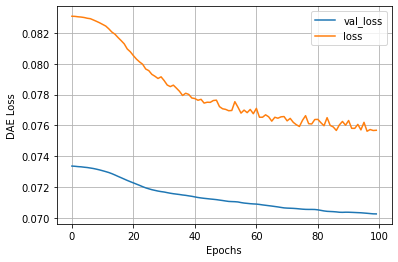

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 916us/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 157us/step - loss: 0.0831 - val_loss: 0.0733
Epoch 3/100
157/157 [==============================] - 0s 162us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 4/100
157/157 [==============================] - 0s 137us/step - loss: 0.0830 - val_loss: 0.0732
Epoch 5/100
157/157 [==============================] - 0s 117us/step - loss: 0.0829 - val_loss: 0.0731
Epoch 6/100
157/157 [==============================] - 0s 151us/step - loss: 0.0828 - val_loss: 0.0730
Epoch 7/100
157/157 [==============================] - 0s 129us/step - loss: 0.0827 - val_loss: 0.0728
Epoch 8/100
157/157 [==============================] - 0s 155us/step - loss: 0.0826 - val_loss: 0.0726
Epoch 9/100
157/157 [==============================] - 0s 124us/step - loss: 0.0824 - val_loss: 0.0724
Epoch 10/100
157/157 [======

<Figure size 432x288 with 0 Axes>

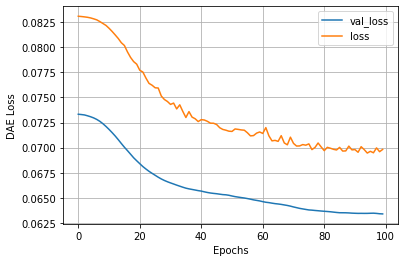

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0833 - val_loss: 0.0734
Epoch 2/100
157/157 [==============================] - 0s 144us/step - loss: 0.0831 - val_loss: 0.0734
Epoch 3/100
157/157 [==============================] - 0s 164us/step - loss: 0.0831 - val_loss: 0.0734
Epoch 4/100
157/157 [==============================] - 0s 104us/step - loss: 0.0830 - val_loss: 0.0734
Epoch 5/100
157/157 [==============================] - 0s 117us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 6/100
157/157 [==============================] - 0s 111us/step - loss: 0.0829 - val_loss: 0.0733
Epoch 7/100
157/157 [==============================] - 0s 104us/step - loss: 0.0829 - val_loss: 0.0733
Epoch 8/100
157/157 [==============================] - 0s 124us/step - loss: 0.0827 - val_loss: 0.0733
Epoch 9/100
157/157 [==============================] - 0s 123us/step - loss: 0.0827 - val_loss: 0.0732
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

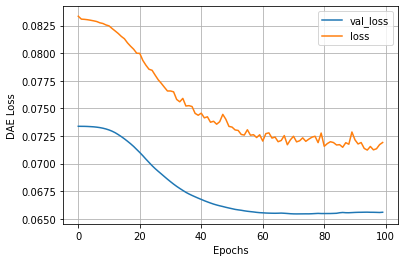

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 1ms/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 137us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 3/100
157/157 [==============================] - 0s 129us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 4/100
157/157 [==============================] - 0s 126us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 5/100
157/157 [==============================] - 0s 119us/step - loss: 0.0828 - val_loss: 0.0731
Epoch 6/100
157/157 [==============================] - 0s 120us/step - loss: 0.0827 - val_loss: 0.0730
Epoch 7/100
157/157 [==============================] - 0s 112us/step - loss: 0.0825 - val_loss: 0.0729
Epoch 8/100
157/157 [==============================] - 0s 126us/step - loss: 0.0823 - val_loss: 0.0727
Epoch 9/100
157/157 [==============================] - 0s 122us/step - loss: 0.0820 - val_loss: 0.0724
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

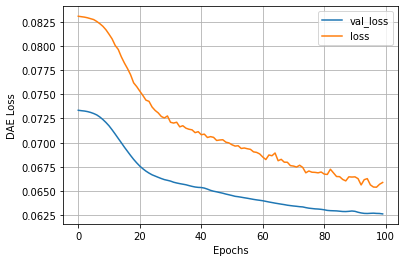

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 179us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 3/100
157/157 [==============================] - 0s 141us/step - loss: 0.0830 - val_loss: 0.0732
Epoch 4/100
157/157 [==============================] - 0s 113us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 5/100
157/157 [==============================] - 0s 131us/step - loss: 0.0828 - val_loss: 0.0731
Epoch 6/100
157/157 [==============================] - 0s 117us/step - loss: 0.0826 - val_loss: 0.0730
Epoch 7/100
157/157 [==============================] - 0s 122us/step - loss: 0.0824 - val_loss: 0.0728
Epoch 8/100
157/157 [==============================] - 0s 112us/step - loss: 0.0821 - val_loss: 0.0726
Epoch 9/100
157/157 [==============================] - 0s 135us/step - loss: 0.0818 - val_loss: 0.0723
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

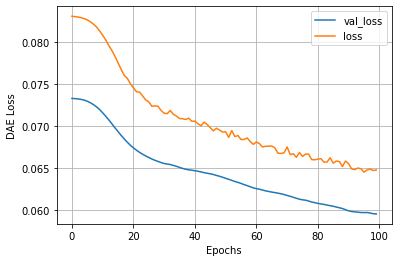

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 187us/step - loss: 0.0830 - val_loss: 0.0732
Epoch 3/100
157/157 [==============================] - 0s 134us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 4/100
157/157 [==============================] - 0s 159us/step - loss: 0.0828 - val_loss: 0.0730
Epoch 5/100
157/157 [==============================] - 0s 132us/step - loss: 0.0826 - val_loss: 0.0729
Epoch 6/100
157/157 [==============================] - 0s 115us/step - loss: 0.0824 - val_loss: 0.0727
Epoch 7/100
157/157 [==============================] - 0s 212us/step - loss: 0.0821 - val_loss: 0.0724
Epoch 8/100
157/157 [==============================] - 0s 124us/step - loss: 0.0817 - val_loss: 0.0721
Epoch 9/100
157/157 [==============================] - 0s 132us/step - loss: 0.0813 - val_loss: 0.0717
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

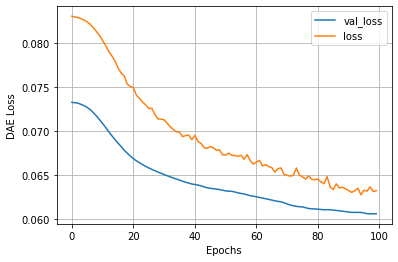

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 165us/step - loss: 0.0830 - val_loss: 0.0732
Epoch 3/100
157/157 [==============================] - 0s 136us/step - loss: 0.0829 - val_loss: 0.0731
Epoch 4/100
157/157 [==============================] - 0s 129us/step - loss: 0.0828 - val_loss: 0.0730
Epoch 5/100
157/157 [==============================] - 0s 127us/step - loss: 0.0826 - val_loss: 0.0728
Epoch 6/100
157/157 [==============================] - 0s 134us/step - loss: 0.0824 - val_loss: 0.0726
Epoch 7/100
157/157 [==============================] - 0s 142us/step - loss: 0.0821 - val_loss: 0.0722
Epoch 8/100
157/157 [==============================] - 0s 133us/step - loss: 0.0818 - val_loss: 0.0718
Epoch 9/100
157/157 [==============================] - 0s 131us/step - loss: 0.0813 - val_loss: 0.0714
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

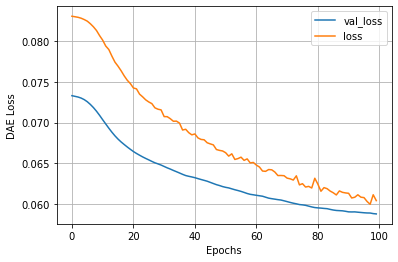

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 151us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 3/100
157/157 [==============================] - 0s 142us/step - loss: 0.0828 - val_loss: 0.0731
Epoch 4/100
157/157 [==============================] - 0s 114us/step - loss: 0.0827 - val_loss: 0.0730
Epoch 5/100
157/157 [==============================] - 0s 144us/step - loss: 0.0825 - val_loss: 0.0728
Epoch 6/100
157/157 [==============================] - 0s 191us/step - loss: 0.0822 - val_loss: 0.0725
Epoch 7/100
157/157 [==============================] - 0s 130us/step - loss: 0.0818 - val_loss: 0.0722
Epoch 8/100
157/157 [==============================] - 0s 133us/step - loss: 0.0814 - val_loss: 0.0718
Epoch 9/100
157/157 [==============================] - 0s 133us/step - loss: 0.0808 - val_loss: 0.0713
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

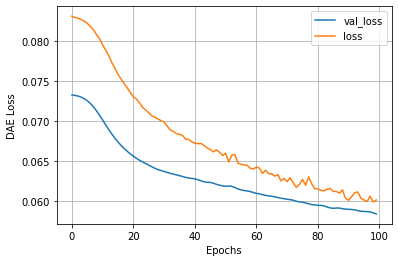

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 149us/step - loss: 0.0830 - val_loss: 0.0733
Epoch 3/100
157/157 [==============================] - 0s 138us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 4/100
157/157 [==============================] - 0s 137us/step - loss: 0.0828 - val_loss: 0.0732
Epoch 5/100
157/157 [==============================] - 0s 165us/step - loss: 0.0826 - val_loss: 0.0731
Epoch 6/100
157/157 [==============================] - 0s 131us/step - loss: 0.0824 - val_loss: 0.0729
Epoch 7/100
157/157 [==============================] - 0s 143us/step - loss: 0.0821 - val_loss: 0.0727
Epoch 8/100
157/157 [==============================] - 0s 133us/step - loss: 0.0817 - val_loss: 0.0725
Epoch 9/100
157/157 [==============================] - 0s 178us/step - loss: 0.0813 - val_loss: 0.0722
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

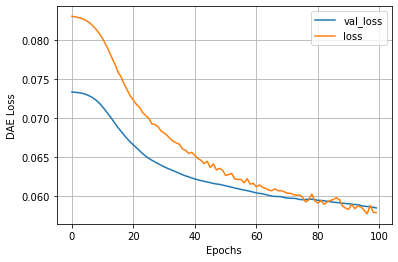

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0732
Epoch 2/100
157/157 [==============================] - 0s 164us/step - loss: 0.0829 - val_loss: 0.0731
Epoch 3/100
157/157 [==============================] - 0s 136us/step - loss: 0.0828 - val_loss: 0.0729
Epoch 4/100
157/157 [==============================] - 0s 138us/step - loss: 0.0826 - val_loss: 0.0728
Epoch 5/100
157/157 [==============================] - 0s 137us/step - loss: 0.0824 - val_loss: 0.0726
Epoch 6/100
157/157 [==============================] - 0s 131us/step - loss: 0.0822 - val_loss: 0.0724
Epoch 7/100
157/157 [==============================] - 0s 127us/step - loss: 0.0818 - val_loss: 0.0721
Epoch 8/100
157/157 [==============================] - 0s 121us/step - loss: 0.0814 - val_loss: 0.0717
Epoch 9/100
157/157 [==============================] - 0s 134us/step - loss: 0.0809 - val_loss: 0.0713
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

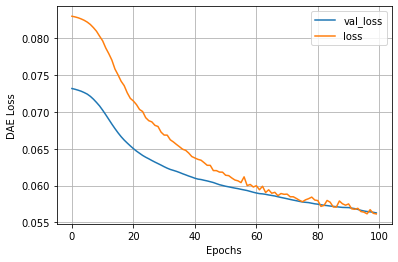

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 3ms/step - loss: 0.0831 - val_loss: 0.0733
Epoch 2/100
157/157 [==============================] - 0s 157us/step - loss: 0.0829 - val_loss: 0.0732
Epoch 3/100
157/157 [==============================] - 0s 151us/step - loss: 0.0828 - val_loss: 0.0732
Epoch 4/100
157/157 [==============================] - 0s 140us/step - loss: 0.0827 - val_loss: 0.0731
Epoch 5/100
157/157 [==============================] - 0s 143us/step - loss: 0.0825 - val_loss: 0.0730
Epoch 6/100
157/157 [==============================] - 0s 144us/step - loss: 0.0822 - val_loss: 0.0728
Epoch 7/100
157/157 [==============================] - 0s 133us/step - loss: 0.0819 - val_loss: 0.0726
Epoch 8/100
157/157 [==============================] - 0s 137us/step - loss: 0.0814 - val_loss: 0.0723
Epoch 9/100
157/157 [==============================] - 0s 164us/step - loss: 0.0809 - val_loss: 0.0719
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

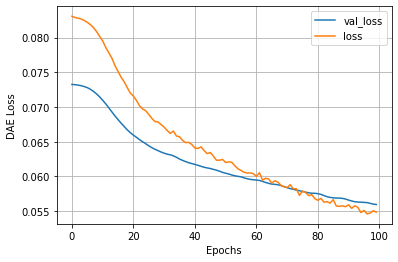

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 0s 3ms/step - loss: 0.0830 - val_loss: 0.0731
Epoch 2/100
157/157 [==============================] - 0s 152us/step - loss: 0.0828 - val_loss: 0.0730
Epoch 3/100
157/157 [==============================] - 0s 147us/step - loss: 0.0826 - val_loss: 0.0728
Epoch 4/100
157/157 [==============================] - 0s 141us/step - loss: 0.0824 - val_loss: 0.0726
Epoch 5/100
157/157 [==============================] - 0s 231us/step - loss: 0.0821 - val_loss: 0.0724
Epoch 6/100
157/157 [==============================] - 0s 164us/step - loss: 0.0817 - val_loss: 0.0720
Epoch 7/100
157/157 [==============================] - 0s 161us/step - loss: 0.0812 - val_loss: 0.0716
Epoch 8/100
157/157 [==============================] - 0s 139us/step - loss: 0.0806 - val_loss: 0.0711
Epoch 9/100
157/157 [==============================] - 0s 144us/step - loss: 0.0799 - val_loss: 0.0705
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

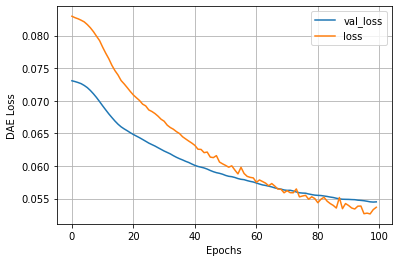

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 0.0831 - val_loss: 0.0731
Epoch 2/100
157/157 [==============================] - 0s 162us/step - loss: 0.0828 - val_loss: 0.0729
Epoch 3/100
157/157 [==============================] - 0s 140us/step - loss: 0.0826 - val_loss: 0.0727
Epoch 4/100
157/157 [==============================] - 0s 155us/step - loss: 0.0824 - val_loss: 0.0725
Epoch 5/100
157/157 [==============================] - 0s 211us/step - loss: 0.0821 - val_loss: 0.0722
Epoch 6/100
157/157 [==============================] - 0s 147us/step - loss: 0.0816 - val_loss: 0.0718
Epoch 7/100
157/157 [==============================] - 0s 165us/step - loss: 0.0811 - val_loss: 0.0713
Epoch 8/100
157/157 [==============================] - 0s 164us/step - loss: 0.0804 - val_loss: 0.0707
Epoch 9/100
157/157 [==============================] - 0s 145us/step - loss: 0.0797 - val_loss: 0.0701
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

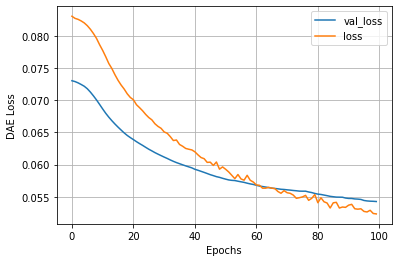

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 3ms/step - loss: 0.0830 - val_loss: 0.0732
Epoch 2/100
157/157 [==============================] - 0s 152us/step - loss: 0.0828 - val_loss: 0.0730
Epoch 3/100
157/157 [==============================] - 0s 146us/step - loss: 0.0827 - val_loss: 0.0729
Epoch 4/100
157/157 [==============================] - 0s 174us/step - loss: 0.0825 - val_loss: 0.0727
Epoch 5/100
157/157 [==============================] - 0s 146us/step - loss: 0.0822 - val_loss: 0.0724
Epoch 6/100
157/157 [==============================] - 0s 151us/step - loss: 0.0818 - val_loss: 0.0720
Epoch 7/100
157/157 [==============================] - 0s 172us/step - loss: 0.0812 - val_loss: 0.0715
Epoch 8/100
157/157 [==============================] - 0s 151us/step - loss: 0.0805 - val_loss: 0.0709
Epoch 9/100
157/157 [==============================] - 0s 136us/step - loss: 0.0797 - val_loss: 0.0701
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

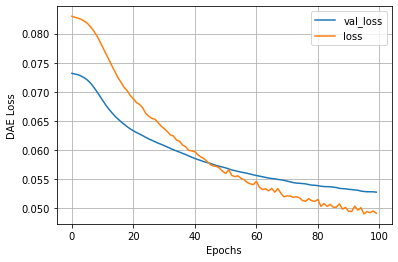

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0828 - val_loss: 0.0731
Epoch 2/100
157/157 [==============================] - 0s 165us/step - loss: 0.0827 - val_loss: 0.0730
Epoch 3/100
157/157 [==============================] - 0s 183us/step - loss: 0.0825 - val_loss: 0.0728
Epoch 4/100
157/157 [==============================] - 0s 155us/step - loss: 0.0822 - val_loss: 0.0726
Epoch 5/100
157/157 [==============================] - 0s 142us/step - loss: 0.0818 - val_loss: 0.0722
Epoch 6/100
157/157 [==============================] - 0s 155us/step - loss: 0.0812 - val_loss: 0.0718
Epoch 7/100
157/157 [==============================] - 0s 157us/step - loss: 0.0805 - val_loss: 0.0712
Epoch 8/100
157/157 [==============================] - 0s 160us/step - loss: 0.0796 - val_loss: 0.0705
Epoch 9/100
157/157 [==============================] - 0s 154us/step - loss: 0.0786 - val_loss: 0.0698
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

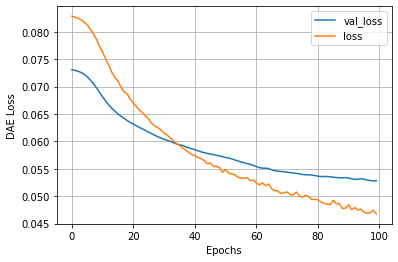

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0830 - val_loss: 0.0730
Epoch 2/100
157/157 [==============================] - 0s 166us/step - loss: 0.0825 - val_loss: 0.0728
Epoch 3/100
157/157 [==============================] - 0s 170us/step - loss: 0.0823 - val_loss: 0.0725
Epoch 4/100
157/157 [==============================] - 0s 180us/step - loss: 0.0819 - val_loss: 0.0722
Epoch 5/100
157/157 [==============================] - 0s 169us/step - loss: 0.0814 - val_loss: 0.0717
Epoch 6/100
157/157 [==============================] - 0s 152us/step - loss: 0.0807 - val_loss: 0.0711
Epoch 7/100
157/157 [==============================] - 0s 155us/step - loss: 0.0799 - val_loss: 0.0703
Epoch 8/100
157/157 [==============================] - 0s 176us/step - loss: 0.0789 - val_loss: 0.0695
Epoch 9/100
157/157 [==============================] - 0s 175us/step - loss: 0.0778 - val_loss: 0.0686
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

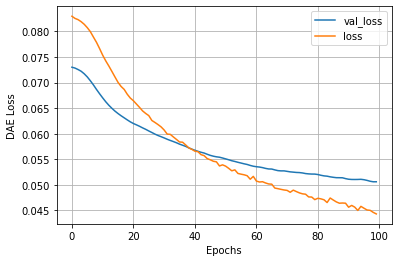

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0832 - val_loss: 0.0730
Epoch 2/100
157/157 [==============================] - 0s 195us/step - loss: 0.0826 - val_loss: 0.0728
Epoch 3/100
157/157 [==============================] - 0s 197us/step - loss: 0.0824 - val_loss: 0.0725
Epoch 4/100
157/157 [==============================] - 0s 190us/step - loss: 0.0820 - val_loss: 0.0722
Epoch 5/100
157/157 [==============================] - 0s 187us/step - loss: 0.0815 - val_loss: 0.0717
Epoch 6/100
157/157 [==============================] - 0s 181us/step - loss: 0.0808 - val_loss: 0.0711
Epoch 7/100
157/157 [==============================] - 0s 196us/step - loss: 0.0799 - val_loss: 0.0703
Epoch 8/100
157/157 [==============================] - 0s 229us/step - loss: 0.0789 - val_loss: 0.0695
Epoch 9/100
157/157 [==============================] - 0s 195us/step - loss: 0.0777 - val_loss: 0.0685
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

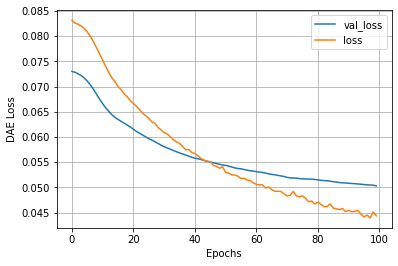

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 4ms/step - loss: 0.0831 - val_loss: 0.0726
Epoch 2/100
157/157 [==============================] - 0s 215us/step - loss: 0.0823 - val_loss: 0.0724
Epoch 3/100
157/157 [==============================] - 0s 187us/step - loss: 0.0820 - val_loss: 0.0720
Epoch 4/100
157/157 [==============================] - 0s 210us/step - loss: 0.0815 - val_loss: 0.0715
Epoch 5/100
157/157 [==============================] - 0s 204us/step - loss: 0.0809 - val_loss: 0.0708
Epoch 6/100
157/157 [==============================] - 0s 199us/step - loss: 0.0800 - val_loss: 0.0701
Epoch 7/100
157/157 [==============================] - 0s 176us/step - loss: 0.0789 - val_loss: 0.0691
Epoch 8/100
157/157 [==============================] - 0s 199us/step - loss: 0.0777 - val_loss: 0.0681
Epoch 9/100
157/157 [==============================] - 0s 223us/step - loss: 0.0764 - val_loss: 0.0672
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

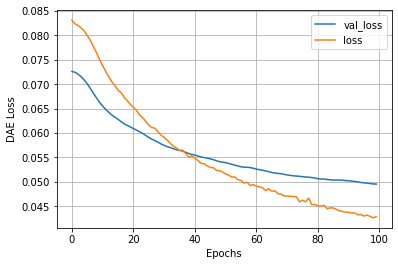

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0828 - val_loss: 0.0726
Epoch 2/100
157/157 [==============================] - 0s 191us/step - loss: 0.0822 - val_loss: 0.0724
Epoch 3/100
157/157 [==============================] - 0s 201us/step - loss: 0.0819 - val_loss: 0.0719
Epoch 4/100
157/157 [==============================] - 0s 208us/step - loss: 0.0812 - val_loss: 0.0714
Epoch 5/100
157/157 [==============================] - 0s 185us/step - loss: 0.0804 - val_loss: 0.0706
Epoch 6/100
157/157 [==============================] - 0s 206us/step - loss: 0.0794 - val_loss: 0.0697
Epoch 7/100
157/157 [==============================] - 0s 183us/step - loss: 0.0781 - val_loss: 0.0688
Epoch 8/100
157/157 [==============================] - 0s 197us/step - loss: 0.0768 - val_loss: 0.0678
Epoch 9/100
157/157 [==============================] - 0s 208us/step - loss: 0.0753 - val_loss: 0.0668
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

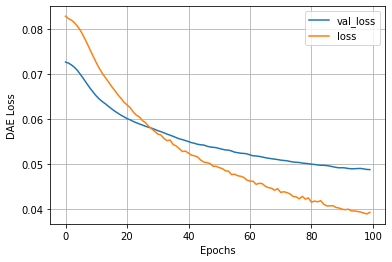

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0827 - val_loss: 0.0726
Epoch 2/100
157/157 [==============================] - 0s 220us/step - loss: 0.0822 - val_loss: 0.0722
Epoch 3/100
157/157 [==============================] - 0s 216us/step - loss: 0.0817 - val_loss: 0.0717
Epoch 4/100
157/157 [==============================] - 0s 209us/step - loss: 0.0811 - val_loss: 0.0710
Epoch 5/100
157/157 [==============================] - 0s 209us/step - loss: 0.0803 - val_loss: 0.0702
Epoch 6/100
157/157 [==============================] - 0s 217us/step - loss: 0.0792 - val_loss: 0.0692
Epoch 7/100
157/157 [==============================] - 0s 199us/step - loss: 0.0779 - val_loss: 0.0680
Epoch 8/100
157/157 [==============================] - 0s 220us/step - loss: 0.0766 - val_loss: 0.0669
Epoch 9/100
157/157 [==============================] - 0s 208us/step - loss: 0.0749 - val_loss: 0.0659
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

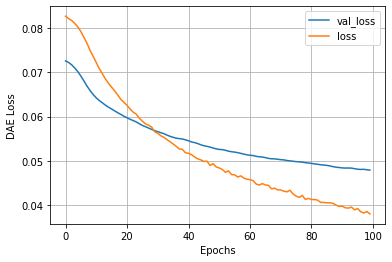

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0825 - val_loss: 0.0724
Epoch 2/100
157/157 [==============================] - 0s 247us/step - loss: 0.0819 - val_loss: 0.0721
Epoch 3/100
157/157 [==============================] - 0s 247us/step - loss: 0.0814 - val_loss: 0.0715
Epoch 4/100
157/157 [==============================] - 0s 241us/step - loss: 0.0806 - val_loss: 0.0707
Epoch 5/100
157/157 [==============================] - 0s 262us/step - loss: 0.0795 - val_loss: 0.0698
Epoch 6/100
157/157 [==============================] - 0s 241us/step - loss: 0.0781 - val_loss: 0.0686
Epoch 7/100
157/157 [==============================] - 0s 234us/step - loss: 0.0766 - val_loss: 0.0674
Epoch 8/100
157/157 [==============================] - 0s 239us/step - loss: 0.0749 - val_loss: 0.0663
Epoch 9/100
157/157 [==============================] - 0s 246us/step - loss: 0.0734 - val_loss: 0.0652
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

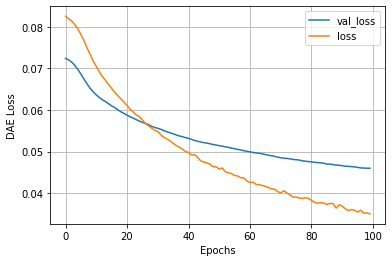

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 5ms/step - loss: 0.0825 - val_loss: 0.0721
Epoch 2/100
157/157 [==============================] - 0s 290us/step - loss: 0.0816 - val_loss: 0.0716
Epoch 3/100
157/157 [==============================] - 0s 236us/step - loss: 0.0808 - val_loss: 0.0708
Epoch 4/100
157/157 [==============================] - 0s 270us/step - loss: 0.0799 - val_loss: 0.0698
Epoch 5/100
157/157 [==============================] - 0s 251us/step - loss: 0.0786 - val_loss: 0.0688
Epoch 6/100
157/157 [==============================] - 0s 270us/step - loss: 0.0770 - val_loss: 0.0675
Epoch 7/100
157/157 [==============================] - 0s 280us/step - loss: 0.0754 - val_loss: 0.0663
Epoch 8/100
157/157 [==============================] - 0s 253us/step - loss: 0.0737 - val_loss: 0.0652
Epoch 9/100
157/157 [==============================] - 0s 256us/step - loss: 0.0719 - val_loss: 0.0642
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

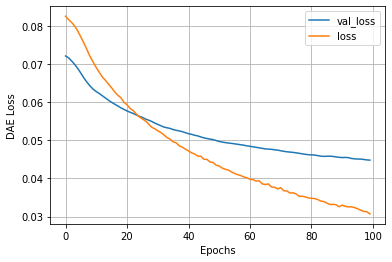

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0827 - val_loss: 0.0721
Epoch 2/100
157/157 [==============================] - 0s 270us/step - loss: 0.0815 - val_loss: 0.0717
Epoch 3/100
157/157 [==============================] - 0s 269us/step - loss: 0.0809 - val_loss: 0.0709
Epoch 4/100
157/157 [==============================] - 0s 311us/step - loss: 0.0798 - val_loss: 0.0700
Epoch 5/100
157/157 [==============================] - 0s 244us/step - loss: 0.0785 - val_loss: 0.0689
Epoch 6/100
157/157 [==============================] - 0s 242us/step - loss: 0.0769 - val_loss: 0.0677
Epoch 7/100
157/157 [==============================] - 0s 239us/step - loss: 0.0751 - val_loss: 0.0664
Epoch 8/100
157/157 [==============================] - 0s 280us/step - loss: 0.0732 - val_loss: 0.0652
Epoch 9/100
157/157 [==============================] - 0s 242us/step - loss: 0.0715 - val_loss: 0.0641
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

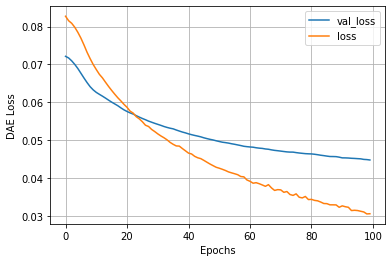

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0825 - val_loss: 0.0720
Epoch 2/100
157/157 [==============================] - 0s 289us/step - loss: 0.0813 - val_loss: 0.0715
Epoch 3/100
157/157 [==============================] - 0s 314us/step - loss: 0.0806 - val_loss: 0.0707
Epoch 4/100
157/157 [==============================] - 0s 254us/step - loss: 0.0794 - val_loss: 0.0696
Epoch 5/100
157/157 [==============================] - 0s 268us/step - loss: 0.0779 - val_loss: 0.0683
Epoch 6/100
157/157 [==============================] - 0s 265us/step - loss: 0.0761 - val_loss: 0.0668
Epoch 7/100
157/157 [==============================] - 0s 243us/step - loss: 0.0741 - val_loss: 0.0654
Epoch 8/100
157/157 [==============================] - 0s 242us/step - loss: 0.0723 - val_loss: 0.0641
Epoch 9/100
157/157 [==============================] - 0s 246us/step - loss: 0.0704 - val_loss: 0.0631
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

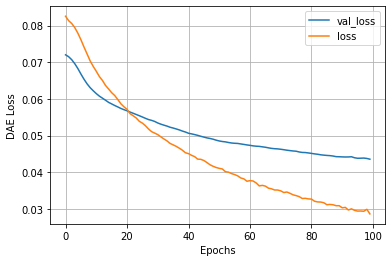

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0823 - val_loss: 0.0718
Epoch 2/100
157/157 [==============================] - 0s 376us/step - loss: 0.0811 - val_loss: 0.0711
Epoch 3/100
157/157 [==============================] - 0s 263us/step - loss: 0.0803 - val_loss: 0.0702
Epoch 4/100
157/157 [==============================] - 0s 250us/step - loss: 0.0790 - val_loss: 0.0691
Epoch 5/100
157/157 [==============================] - 0s 264us/step - loss: 0.0774 - val_loss: 0.0678
Epoch 6/100
157/157 [==============================] - 0s 275us/step - loss: 0.0756 - val_loss: 0.0664
Epoch 7/100
157/157 [==============================] - 0s 265us/step - loss: 0.0736 - val_loss: 0.0650
Epoch 8/100
157/157 [==============================] - 0s 348us/step - loss: 0.0717 - val_loss: 0.0638
Epoch 9/100
157/157 [==============================] - 0s 286us/step - loss: 0.0698 - val_loss: 0.0629
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

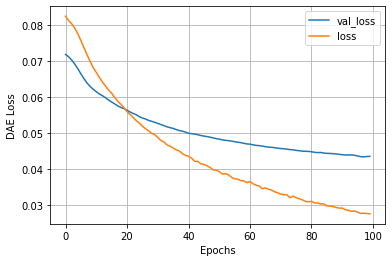

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 6ms/step - loss: 0.0823 - val_loss: 0.0713
Epoch 2/100
157/157 [==============================] - 0s 359us/step - loss: 0.0807 - val_loss: 0.0705
Epoch 3/100
157/157 [==============================] - 0s 283us/step - loss: 0.0797 - val_loss: 0.0694
Epoch 4/100
157/157 [==============================] - 0s 292us/step - loss: 0.0783 - val_loss: 0.0680
Epoch 5/100
157/157 [==============================] - 0s 314us/step - loss: 0.0765 - val_loss: 0.0665
Epoch 6/100
157/157 [==============================] - 0s 287us/step - loss: 0.0743 - val_loss: 0.0651
Epoch 7/100
157/157 [==============================] - 0s 313us/step - loss: 0.0721 - val_loss: 0.0638
Epoch 8/100
157/157 [==============================] - 0s 336us/step - loss: 0.0702 - val_loss: 0.0628
Epoch 9/100
157/157 [==============================] - 0s 319us/step - loss: 0.0684 - val_loss: 0.0618
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

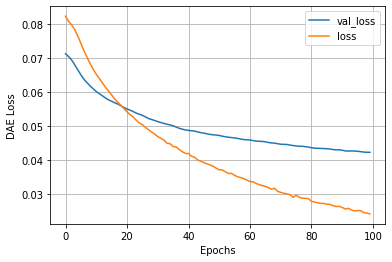

Train on 157 samples, validate on 18 samples
Epoch 1/100
157/157 [==============================] - 1s 7ms/step - loss: 0.0820 - val_loss: 0.0709
Epoch 2/100
157/157 [==============================] - 0s 340us/step - loss: 0.0804 - val_loss: 0.0702
Epoch 3/100
157/157 [==============================] - 0s 349us/step - loss: 0.0792 - val_loss: 0.0688
Epoch 4/100
157/157 [==============================] - 0s 322us/step - loss: 0.0775 - val_loss: 0.0674
Epoch 5/100
157/157 [==============================] - 0s 332us/step - loss: 0.0755 - val_loss: 0.0658
Epoch 6/100
157/157 [==============================] - 0s 318us/step - loss: 0.0733 - val_loss: 0.0642
Epoch 7/100
157/157 [==============================] - 0s 322us/step - loss: 0.0710 - val_loss: 0.0628
Epoch 8/100
157/157 [==============================] - 0s 341us/step - loss: 0.0689 - val_loss: 0.0615
Epoch 9/100
157/157 [==============================] - 0s 344us/step - loss: 0.0669 - val_loss: 0.0605
Epoch 10/100
157/157 [========

<Figure size 432x288 with 0 Axes>

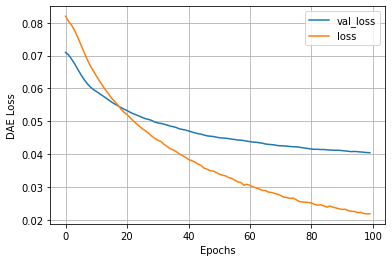

In [9]:
df_hist = []
for latent_dim in k_list:
    dae = Adage(original_dim, latent_dim, noise=0.05, batch_size=50,
                    epochs=100, sparsity=0, learning_rate=0.0005, loss='mse',
                    optimizer='adam', tied_weights=True, verbose=True)
    dae._build_graph()
    dae._build_tied_weights_graph()
    dae._compile_adage()
    dae._connect_layers()
    dae.initialize_model()
    dae.train_adage(pcos_train_df, pcos_test_df)

    plt.figure()
    ax = dae.history_df.plot()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('DAE Loss')
    fig = ax.get_figure()
    plt.grid()
    plt.show()
    fig.savefig("/content/drive/MyDrive/aacb_project/images/dae_latent_"+str(latent_dim)+".png")

    df_hist.append(dae.history_df)

In [10]:
for df,k in zip(df_hist, k_list):
    df.to_csv("/content/drive/MyDrive/aacb_project/data/dae_latent_"+str(k)+".csv")